# Design Optimization of the LV4 Sub-orbital Rocket
## Motivation
Clean-sheet conceptual design and trajectory optimization of launch vehicles is a classically difficult problem. This problem arises for two reasons. The first is that the 1-D trajectory equation is a 2nd order non-linear ordinary differential equation with non-constant coefficients, and has no closed-form solution. Secondly, detailed design choices in propulsion, structures/weights, aerodynamics, and guidance and control which ultimately all appear as variables in the governing equation are both highly coupled and are non-hierarchical. Schematically the coupling between the variables is presented in the figure below. The traditional approach to dealing with this problem has been to evaluate vehicle performance by using "one variable-at-a-time" trade-off analysis. However there are several key limitations to this approach:

* The nature of the coupling between the design variables is poorly understood
* Early conceptual design is usually carried out with low-fidelity models
* Optimizing individual design variables does not usually guarantee optimality at the overall system level

In practice this results in a highly iterative design process and concomitant requirement mismatches, developmental dead-ends, and sub-optimal final design. The problem with sub-optimal design is magnified by the ramifications of Konstantin Tsiolkovsy's equation, with its severe implication of exponential growth in design requirements for linear increases in rocket dry mass. Since ultimately all design decisions impact the rocket dry mass in some way it is imperative to understand these trade-offs and compromises as early in the design process as possible to reduce the potential for technical, schedule, and cost risks. This is especially the case for time, technical expertise, and funding constrained student organizations. Thus there is a strong motivation to treat the conceptual design parameters "all-at-once" using applied convex optimization techniques. A numerical design optimization approach allows us to start to explore this extremely large trade space and point us towards a good "initial guess" for the iterative design process.

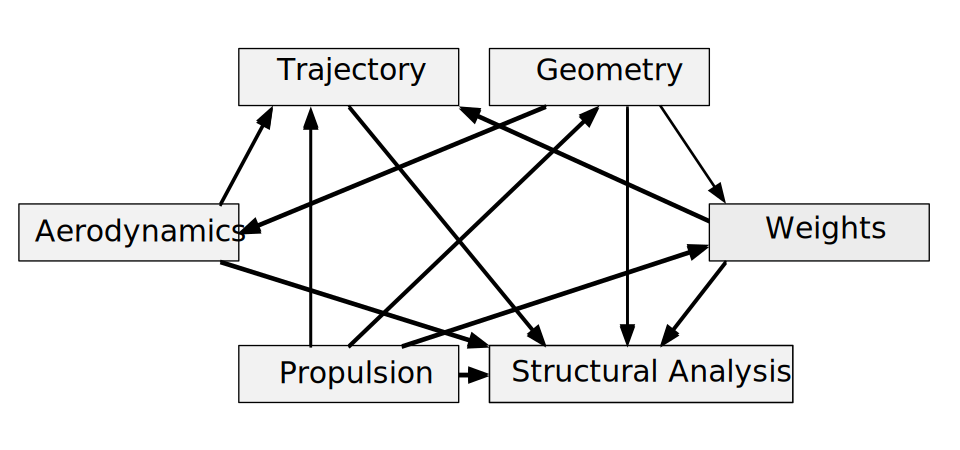

In [1]:
from IPython.display import SVG
SVG(filename='coupling.svg')

Some commercial and governmental tools exist for launch vehicle design optimization. These include
codes such as FASTPASS, and SWORD. There are also open-source design and optimization tools that
can be applied to high-powered rocketry such as Open Rocket, and JSBSim, however these tools either
cannot be run in a batch mode or lack I/O tools to support direct numerical optimization. In the context
of this developing interest in clean-sheet small launch vehicle design we can identify a need for a design tool
high-level enough for simplicity, speed, and ease of use, but which captures enough of the dimensions of the
optimization problem to still be useful as a guide in the early conceptual design phase.

## Methods
We expect overall project costs to scale with the initial mass of the launch vehicle (including the mass of loaded propellants), which is usually defined by the Gross Lift-Off Weight (GLOW). Therefore the objective of the optimization is to minimize GLOW.  

For a top-level early concept development we can distill the key design variables to just thrust, nozzle expansion ratio, airframe diameter and propellant tank lengths. There are also a large number of design constants present in the models, which include specific impulse and combustion chamber pressure, propellant mixture ratio, and others, but which for the sake of brevity will be largely ignored in the following discussion. The model currently includes 6 inequality constraints:

* Apogee $h$: The maximum altitude on the trajectory
* Thrust-to-Weight Ratio $TWR$: Trade-off between gravity loss and aerodynamic stability
* Length to Diameter Ratio $L/D$: Trade-off between aerodynamic stability and mechanical (non-rigid body) resonance modes
* Maximum acceleration $\frac{a_{max}}{g_0}$: Set by the material limits of various launch vehicle subsystems
* Diameter $D$: Manufacturability (current process scale-able from \diameter6" to up to \diameter14") 
* Nozzle over-expansion $\frac{p_e}{p_a}$: Prevents the assumption made to help linearize thrust model from becoming invalid

Mathematically the problem can be stated as

$$ \mbox{min} \hspace{2 mm} m_{initial} = m_{dry}(h) + m_{propellants,  initial}(h) $$


\begin{eqnarray*} \mbox{where} \hspace{5 mm} \begin{split}x = \left\{ \begin{array}{ll}      & \dot{m}\\
          & D\\
          & L\\
          & p_e \end{array} \right. 
          \end{split} \hspace{2 mm} \mbox{subject to} \hspace{2 mm} \begin{split}
          g = \left\{ \begin{array}{ll}
          & 5 \leq L/D \leq 15\\
          & TWR \geq 2\\
          & \frac{p_e}{p_a} \geq 0.5\\
          & 6 \leq D \leq 14\\
          & h \geq 100000\\
          & \frac{a_{max}}{g_0} \leq 15 \end{array} \right. \end{split}\end{eqnarray*}

While the objective function itself is given by a very simple function of the design variables $D$ and $L$, the constraints require a much more complex model. The following section discusses the trajectory simulation model required to capture values of these constraints for any particular design vector.

### Trajectory model
The trajectory of the rocket, in a single degree of freedom, can be best described by altitude $h(t)$, velocity $V(t)$, and total mass $m(t)$ state variables which are functions of time. The initial values of the state variables are given by $h_0$, $V_0$, and $m_0$ respectively. The governing equation of the rocket trajectory is Newton's 2nd law of motion 

$$F = \frac{d(mV)}{dt}.$$

This can be expanded in terms of the sum of forces acting on the rocket during free flight going up to apogee

$$Thrust - Drag - m g_0 = \frac{d}{dt} \left(m \frac{dh}{dt}\right).$$

We usually express drag as
$$F_d = \frac{1}{2} \rho V^2 C_d A$$

where $\rho$ is the local air density, $A$ is the frontal area, $C_d$ is the drag coefficient which for a given airframe geometry is a function of angle-of-attack (which for a 1-DoF system is identically zero), and Mach number. The Mach number is a function given by

$$ \frac{V}{c} = \frac{V}{\sqrt{kRT}} $$

where $c$ is the local speed of sound, $k$ is the gas ratio of specific heats, $R$ is the specific gas constant (assumed constant in altitude), and $T$ is the gas temperature. These numbers, as well as $\rho$, and $p_a$ the ambient pressure, are supplied by the 1976 U.S. Standard Atmosphere model. For simplicity, drag coefficients are interpolated from published aerodynamic data from the 1950's era NACA/USN/NASA Aerobee-150 sounding rocket\cite{aerobee}, which is expected to be dimensionally similar (though not identical to) to the LV4 sounding rocket.

The rocket thrust force, given a huge number of simplifying assumptions, is a function of the mass flow rate design variable, the chamber pressure constant, and the ambient pressure state variable. It is given by
$$F_t = \dot{m}V_e + A_e(p_e - p_a) $$

where $V_e$ is the rocket exhaust velocity, $A_e$ is the rocket nozzle exit area. The exhaust velocity, again given a large number of simplifying assumptions, is given by

$$V_e = \sqrt{\frac{2kRT_{ch}}{k - 1}\left(1 - \left(\frac{p_e}{p_{ch}}\right)^{((k - 1)/k)}\right)}$$

where $T_{ch}$ is the chamber pressure, which along with the combustion chamber gas ratio of specific heats $k$, and gas constant $R$ are functions of the mixture ratio of the propellants, and the chamber pressure $p_{ch}$ determined using the NASA Chemical Equilibrium Analysis (CEA)\cite{CEA} tool and are design constants. It should be noted that the $p_e$ is a design variable tied to the expansion ratio of the rocket engine, but that $p_a$ is constantly changing with altitude. The thrust function is maximized when $p_e = p_a$, however this occurs at one, and only one, altitude. Thus the design expansion ratio selection directly benefits from trajectory optimization. Some additional information about PSAS's liquid propulsion project can be found [here](https://github.com/psas/liquid-engine-capstone-2015).

By finite-differencing the derivatives of the governing equation a first-order Runge-Kutta (e.g. Forward Euler) integration of the governing equation is used to determine the rocket trajectory. This approach was chosen only for simplicity; in principle central differencing or trapezoidal integration are more generally accurate discretization approaches. Forward Euler difference equations always have the form

$$y_{i+1} = y_i + \left(y\hspace{-1 mm}-\hspace{-1 mm}\mbox{rate at } t_i \right)(t_{i+1} - t_i) $$

where $y(t)$ is the state variable being integrated, and $i$ is the time index superscript. In this way the state variables $h$, $V$, and $m$ can be defined at any discrete time $t_0$, $t_1$, $t_2$ ... $t_i$. Given a vector of the four design variables the trajectory function returns numerical values of the objective function and constraint vector. This trajectory code was benchmarked against known trajectory and design data for the Aerobee-150 (sustainer only), and Armadillo Stig-B sounding rockets, and the results compare favorably. This grants us at least some confidence in the assumptions made in the model.

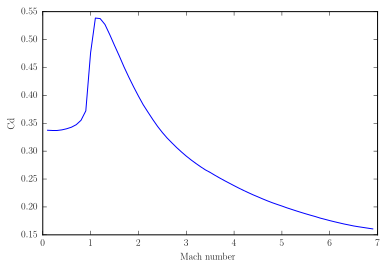

In [2]:
import csv
    
# Drag coefficient look up
C_d_t = []
Ma_t = []
f = open('CD_sustainer_poweron.csv') # Use aerobee 150 drag data
aerobee_cd_data = csv.reader(f, delimiter=',')
for row in aerobee_cd_data:
    C_d_t.append(row[1])
    Ma_t.append(row[0])

# Plot the results
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
%config InlineBackend.figure_formats=['svg']
%matplotlib inline
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

plt.plot(Ma_t, C_d_t)
plt.xlabel('Mach number')
plt.ylabel('Cd')
plt.show()


## Airframe Section Parameters

These are parameters from the current 18" carbon composite airframe modules used in the dry mass model. Further information about this project can be found [here](https://github.com/psas/lv3.0-airframe).

In [3]:
# Airframe Section Parameters
from math import pi
m  = 0.463              # Single LV3 airframe module mass [kg], 18 in.
Do = 0.168              # Outer diameter                  [m]
L  = 0.457              # Length                          [m]
A_fiber = pi * Do *L
rho_fiber = m/A_fiber   # Planar density                  [kg/m^2]
print("Module planar density = {0:.2f} kg/m^2".format(rho_fiber))

Module planar density = 1.92 kg/m^2


## Trjaectory Simulation

In [4]:
from math import sqrt, pi, exp, log, cos
import numpy as np


# A simple forward Euler integration for rocket trajectories
def dry_mass(L, dia):
    m_avionics = 3.3                                                         # Avionics mass [kg]
    m_recovery = 4                                                           # Recovery system mass [kg]
    m_payload = 1 + 3                                                        # Payload mass [kg]
    m_tank_fudgefactor = 1.5
    m_tankage = rho_fiber * m_tank_fudgefactor * L * dia * pi + 3                 # Tank mass Estimation [kg]
    m_engine = 3                                                             # Engine mass [kg]
    m_feedsys = 10                                                           # Feed system mass [kg]
    len_airframe = 1                                                         # Length of Airframe (sans tankage) [m]
    m_airframe  = rho_fiber * m_tank_fudgefactor * len_airframe * dia * pi + 1    # Airframe mass [kg]
    return (m_avionics + m_recovery + m_payload + m_tankage 
    + m_engine + m_feedsys + m_airframe)                                     # Total dry mass [kg]
    
def propellant_mass(A, L, OF=1.3):
    rho_alc = 852.3             # Density, ethanol fuel [kg/m^3]
    rho_lox = 1141.0            # Density, lox          [kg/m^3]
    L_lox = L/(rho_lox/(rho_alc*OF) + 1)
    m_lox = rho_lox*L_lox*A     # Oxidizer mass         [kg]
    m_alc = rho_alc*(L-L_lox)*A # Fuel mass             [kg]
    return m_alc + m_lox        # Propellant Mass       [kg]

def std_at(h):                  # U.S. 1976 Standard Atmosphere
    if h < 11000:
        T = 15.04 - 0.00649*h
        p = 101.29*((T + 273.1)/288.08)**5.256

    elif 11000 <= h and h <25000:
        T = -56.46
        p = 22.65*exp(1.73 - 0.000157*h)

    else:
        T = -131.21 + 0.00299*h
        p = 2.488 * ((T + 273.1)/216.6)**(-11.388)

    rho = p/(0.2869*(T + 273.1)) # Ambient air density [kg/m^3]
    p_a = p*1000                 # Ambient air pressure [Pa]
    T_a = T + 273.1              # Ambient air temperature [K]
    return p_a, rho, T_a

def thrust(x, p_ch, T_ch, p_e, ke, Re, mdot):
    p_a = std_at(x)[0]                                          # Ambient air pressure [Pa]
    p_t = p_ch * (1 + (ke - 1)/2)**(-ke/(ke - 1))               # Throat pressure      [Pa]
    T_t = T_ch * (1/(1 + (ke - 1)/2))                           # Throat temperature   [K]
    A_t = (mdot / p_t) * sqrt(Re * T_t/ke)                      # Throat area          [m^2]
    A_e = A_t * (2/(ke + 1))**(1/(ke - 1)) * (p_ch/p_e)**(1/ke) * \
    1/sqrt((ke + 1)/(ke - 1) * (1 - (p_e/p_ch)**((ke - 1)/ke)))    # Exit area [m^2]
    
    ex = A_e/A_t                                                 # Expansion ratio
    #alpha_t = [14, 11, 10, 9]                                    # Lookup table of divergence angles, assuming 80% bell length
    #ex_t = [5, 10, 15, 20]                                       # Lookup table of expansion ratios from alpha_t
    #alpha= np.interp(ex, ex_t, alpha_t)
    #lam = 0.5 * (1 + cos(alpha * pi/180))                        # Thrust cosine loss correction (not an O(1) effect, even in extreme cases) 
    lam = 1
    Ve = lam * sqrt(2 * ke/(ke - 1) * Re * T_ch * \
    (1 - (p_e/p_ch)**((ke - 1)/ke))) * 0.9                       # Exhaust velocity    [m/s]
    
    F = mdot * Ve + (p_e - p_a) * A_e                            # Thrust force, ignoring that isp increases w/ p_ch [N]
    return F, A_t, A_e, Ve

def drag(x, v, A, Ma, C_d_t, Ma_t):
    (p_a, rho, T_a) = std_at(x)
    
    #C_d_t = [0.15, 0.15, 0.3, 0.45, 0.25, 0.2, 0.175, .15, .15] # V2 rocket drag coefficient lookup table
    #Ma_t = [0, 0.6, 1.0, 1.1, 2, 3, 4, 5, 5.6]                  # V2 rocket Mach number lookup table
    C_d = np.interp(Ma, Ma_t, C_d_t)                            # Drag coefficient function
    q = 0.5 * rho * v**2                                        # Dyanmic pressure [Pa]
    D = q * C_d * A                                             # Drag force       [N]
    return D, q

def trajectory(L, mdot, dia, p_e, p_ch=350, T_ch=3500, ke=1.3, Re=349, x_init=0):
    # Note combustion gas properties ke, Re, T_ch, etc, determined from CEA
    # Physical constants
    g_0 = 9.81 # Gravitational acceleration [m/s^2]
    dt = 1     # Time step                  [s]
    ka = 1.4   # Ratio of specific heats, air  
    Ra = 287.1 # Avg. specific gas constant (dry air)
    
    # LV4 design variables
    dia = dia*0.0254       # Convert in. to m
    A = pi*(dia/2)**2      # Airframe frontal area projected onto a circle of diameter variable dia
    m_dry = dry_mass(L, A) # Dry mass, call from function dry_mass()
    mdot = mdot            # Mass flow rate [kg/s]
    p_ch = p_ch*6894.76    # Chamber pressure, convert psi to Pa
    p_e = p_e*1000         # Exit pressure, convert kPa to Pa

    # Initial conditions
    x = [x_init]
    v = [0]
    a = [0]
    t = [0]
    rho = [std_at(x[-1])[1]]
    p_a = [std_at(x[-1])[0]]
    T_a = [std_at(x[-1])[2]]
    m_prop = [propellant_mass(A, L)]
    m = [m_dry + m_prop[-1]]
    (F, A_t, A_e, Ve) = thrust(x[-1], p_ch, T_ch, p_e, ke, Re, mdot)
    F = [F]
    D = [0]
    Ma = [0]
    q = [0]
    r = (m_prop[0] + m_dry)/m_dry # Mass ratio
    dV1 = Ve*log(r)/1000          # Tsiolkovsky's bane (delta-V)

    while True:
        p_a.append(std_at(x[-1])[0])
        rho.append(std_at(x[-1])[1])
        T_a.append(std_at(x[-1])[2])
        # Check of the propellant tanks are empty
        if m_prop[-1] > 0:
            (Fr, A_t, A_e, Ve) = thrust(x[-1], p_ch, T_ch, p_e, ke, Re, mdot)
            F.append(Fr)
            m_prop.append(m_prop[-1] - mdot*dt)
            mdot_old = mdot
        else:
            Ve = thrust(x[-1], p_ch, T_ch, p_e, ke, Re, mdot_old)[3]
            F.append(0)
            mdot = 0
            m_prop[-1] = 0
        q.append(drag(x[-1], v[-1], A, Ma[-1], C_d_t, Ma_t)[1])
        D.append(drag(x[-1], v[-1], A, Ma[-1], C_d_t, Ma_t)[0])
        a.append((F[-1] - D[-1])/m[-1] - g_0)
        v.append(a[-1]*dt + v[-1])
        x.append(v[-1]*dt + x[-1]) 
        Ma.append(v[-1]/sqrt(ka*Ra*T_a[-1]))
        t.append(t[-1] + dt)
        m.append(m_dry + m_prop[-1])
        TWR = a[1]/g_0      # Thrust-to-weight ratio constraint
        ex = A_e/A_t
        S_crit = p_e/p_a[0] # Sommerfield criterion constraint
        if v[-1] <= 0:
            x = np.array(x)
            a = np.array(a)
            F = np.array(F)
            D = np.array(D)
            q = np.array(q)
            return x, v, a, t, F, D, Ma, rho, p_a, T_a, TWR, ex, Ve, A_t, dV1, m, S_crit, q, m_prop


## Optimization Scheme
There are several general approaches to design optimization for launch vehicle design found in literature:

* Design of Experiments methods (Taguchi Methods`[1]`, Response Surface Methods`[2]`)
* Gradient methods (steepest descent)
* Stochastic methods (genetic algorithm`[3]`, simulated annealing)

While there are certain advantages to each of these approaches, I only have experience with gradient based methods for the most part. Furthermore the difficulty of differentiating the governing equations, the expected multi-modal nature of the response surface and the discrete nature of some of the variables ($m$, $C_d$, etc.) argue against gradient based methods. We therefore use a fast, gradient free, non-stochastic approach: the Nelder-Mead method (e.g. Simplex Search). The limitations of this choice may become evident for high-dimension problems, but for $x \in \textbf{R}^4$, we expect the algorithm to have no major problems with convergence. Inequality constraints were handled by using an exterior penalty function. To desensitize the results to arbitrary values of numerically large constraints the pseudo-objective function has been non-dimensionalized.

In [5]:
# Pseudo-objective function
global cons_TWR, cons_S_crit, cons_accel, cons_LD, cons_alt

#CHANGE CONSTRAINTS HERE
cons_TWR = 8       # TWR constraint
cons_S_crit = 0.35 # Critical pressure ratio constraint
cons_accel = 15    # Max acceleration constraint
cons_LD = 15       # L/D ratio constraint
cons_alt = 100000  # Min altitude constraint

def f(x, p_ch=350, rp=50): ##CHANGE CHAMBER PRESSURE HERE
    L = x[0]    # Rocket length (m)
    mdot = x[1] # Propellant mass flow rate (kg/s)
    dia = x[2]  # Rocket diameter (in)
    p_e = x[3]  # Pressure (kPa)
    (alt, v, a, t, F, D, Ma, rho, p_a, T_a, TWR, ex, Ve, A_t, dV1, m, S_crit, q, m_prop) \
    = trajectory(L, mdot, dia, p_e, p_ch)


    obj_func = m[0]/m0 + rp*(max(0, (L+2)/(dia*0.0254*cons_LD) - 1)**2 + \
               max(0, -TWR/cons_TWR + 1)**2 + max(0, -S_crit/cons_S_crit + 1)**2 + \
                             max(0, -alt[-1]/cons_alt + 1)**2 + max(0, max(abs(a))/(cons_accel*9.81) - 1)**2)
    return obj_func



In [6]:
##CHANGE INITIAL DESIGN GUESS HERE
L = 1.5    # Rocket length (m)
mdot = 0.453592 * 0.9 * 5 # Propellant mass flow rate (kg/s)
dia = 9  # Rocket diameter (in)
p_e = 40  # Pressure (kPa)
X0 = np.array([L, mdot, dia, p_e])
m0 = trajectory(X0[0], X0[1], X0[2], X0[3])[-4][0] # Initial guess GLOW

from scipy.optimize import minimize
res = minimize(f, X0, method='nelder-mead')  

In [14]:
# Plot the results
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import pylab
%config InlineBackend.figure_formats=['svg']
%matplotlib inline
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

pylab.rcParams['figure.figsize'] = (10.0, 10.0)

def plot_trajectory(res):
    p_ch = 350 # Chamber pressure [psi] **DONT FORGET TO CHANGE THE VALUE IN THE OBJECTIVE FUNCTION IN def f()**
    (alt, v, a, t, F, D, Ma, rho, p_a, T_a, TWR, ex, Ve, A_t, dV1, m, S_crit, q, m_prop) = \
trajectory(res.x[0], res.x[1], res.x[2], res.x[3], p_ch)
    # Rename the optimized output
    L = res.x[0]    
    mdot = res.x[1]
    dia = res.x[2]
    p_e = res.x[3]

    f, (ax1, ax2, ax3, ax4, ax6, ax7, ax8) = plt.subplots(7, sharex=True)
    for n in (ax1, ax2, ax3, ax4, ax6, ax7, ax8):
        n.spines['top'].set_visible(False)
        n.spines['right'].set_visible(False)
        n.yaxis.set_ticks_position('left')
        n.xaxis.set_ticks_position('bottom')
        n.yaxis.labelpad = 20
        
    ax1.plot(t, alt/1000)
    ax1.set_ylabel("Altitude (km)")
    ax1.yaxis.major.locator.set_params(nbins=6)
    ax1.set_title('LV4 Trajectory')
    ax2.plot(t, v)
    ax2.yaxis.major.locator.set_params(nbins=6)
    ax2.set_ylabel("Velocity (m/s)")
    ax3.plot(t, a/9.81)
    ax3.yaxis.major.locator.set_params(nbins=10)
    ax3.set_ylabel("Acceleration/g0")
    ax4.plot(t, F/1000)
    ax4.yaxis.major.locator.set_params(nbins=6)
    ax4.set_ylabel("Thrust (kN)")
    ax6.plot(t, q/1000)
    ax6.yaxis.major.locator.set_params(nbins=6)
    ax6.set_ylabel("Dynamic Pressure (kPa)")
    ax7.plot(t, Ma)
    ax7.yaxis.major.locator.set_params(nbins=6) 
    ax7.set_ylabel("Mach number")
    ax7.set_xlabel("t (s)")
    ax8.plot(t, np.array(m)*0.666*np.array(a))
    #ax8.yaxis.major.locator.set_params(nbins=6) 
    ax8.set_ylabel("LOX Tank Axial Load")
    ax8.set_xlabel("t (s)")
    plt.show()
    
    np.set_printoptions(precision=3)
    print('\n')
    print('OPTIMIZED DESIGN VECTOR')
    print('-----------------------------')
    print('x_optimized                                = ', res.x)
    print('x_initial_guess                            = ', X0)
    print('design tankage length                      = {0:.2f} m'.format(res.x[0]))
    print('design mass flow rate                      = {0:.2f} kg/s'.format(res.x[1]))
    print('design airframe diameter                   = {0:.2f} in.'.format(res.x[2]))
    print('design nozzle exit pressure                = {0:.2f} kPa'.format(res.x[3]))
    print('iterations                                 =', res.nit)
    print('design GLOW                                = {0:.1f} kg'.format(m[0]))
    print('x0 GLOW                                    = {0:.1f} kg'.format( \
          trajectory(X0[0], X0[1], X0[2], X0[3], p_ch)[-4][0]))

    print('\n')
    print('CONSTRAINTS')
    print('-----------------------------')
    print('L/D ratio (c.f. < {})                      = {:.2f}'.format(cons_LD, (L+2)/(dia*0.0254)))
    print('Sommerfield criterion (c.f. pe/pa >= {})   = {:.1f}'.format(cons_S_crit, S_crit))
    print("Max acceleration (c.f. < {})               = {:.2f} g's".format(cons_accel, max(abs(a))/9.81))
    print('TWR at lift off (c.f. > {})                = {:.2f}'.format(cons_TWR, TWR))
    print('altitude at apogee                         = {0:.1f} km'.format(alt[-1]/1000))

    print('\n')
    print('ADDITIONAL INFORMATION')
    print('-----------------------------')
    print('mission time at apogee                     = {0:.1f} s'.format(t[-1]))
    print('design total propellant mass               = {0:.3f} kg'.format(m_prop[0]))
    print('design thrust (sea level)                  = {0:.1f} kN'.format(F[0]/1000))
    j = 0
    for thing in F:
        if thing == 0:
            fdex = j
            break
        j += 1
    print('design thrust (vacuum)                     = {0:.1f} kN'.format(F[fdex - 1]/1000))
    print('design burn time                           = {} s'.format(fdex))
    print('design expansion ratio                     = {0:.1f}'.format(ex))
    print('design throat area                         = {0:.1f} in.^2'.format(A_t/0.0254**2))
    print('design isp                                 = {0:.1f} s'.format(Ve/9.81))
    print('design chamber pressure                    = {0:.1f} psi'.format(p_ch))
    print('design total impulse                       = {0:.1f} kN*s'.format(j*(F[fdex - 1]/1000 + F[0]/1000)/2))
    print('design dV                                  = {0:.1f} km/s'.format(dV1))
    print('estimated minimum required dV              = {0:.1f} km/s'.format( sqrt(2*9.81*alt[-1])/1000))

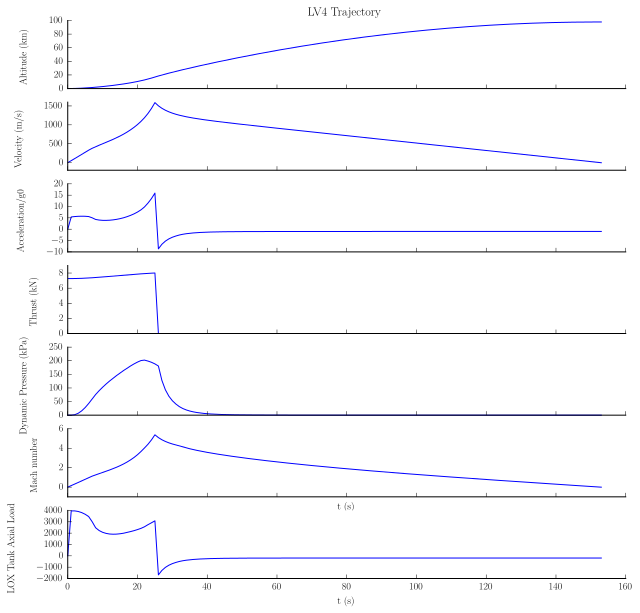



OPTIMIZED DESIGN VECTOR
-----------------------------
x_optimized                                =  [   1.337    3.444   11.306  107.933]
x_initial_guess                            =  [  1.5     2.041   9.     40.   ]
design tankage length                      = 1.34 m
design mass flow rate                      = 3.44 kg/s
design airframe diameter                   = 11.31 in.
design nozzle exit pressure                = 107.93 kPa
iterations                                 = 464
design GLOW                                = 115.8 kg
x0 GLOW                                    = 90.5 kg


CONSTRAINTS
-----------------------------
L/D ratio (c.f. < 15)                      = 11.62
Sommerfield criterion (c.f. pe/pa >= 0.35)   = 1.1
Max acceleration (c.f. < 15)               = 15.90 g's
TWR at lift off (c.f. > 8)                = 5.40
altitude at apogee                         = 97.8 km


ADDITIONAL INFORMATION
-----------------------------
mission time at apogee                     = 153

In [15]:
plot_trajectory(res)

In [ ]:
# Fine Tuning
#res.x = [   1.585,    2.58,     8.987,  60]

#res.x =  [   1.259,    3.11,    10.847,  150.025] #Is an especially good design vector.
#plot_trajectory(res)

##### Discussion of Preliminary Results
As we would expect using Nelder-Mead, the optimized design vector is quite sensitive to the initial guesses. The results appear to always be "feasible" designs, but often several of the constrants appear to be simultaneously active. We attempted to find a more global optima by brute forcing a large array of initial guesses using Montecarlo techniques, and examining the frequency spectra to get a sense of the modality of the response surface. We noticed that there didn't appear to be any regimes of feasible designs with significant improvements in GLOW. There is a multi-modality of the respose surface, but given the parameters in the model the best LV configurations all have GLOW on the order of 100 kg or higher.

By changing values in the `dry_mass` function we can see that there is an enormous sensitivty of GLOW to tank mass and inert dry mass, as we would have expected. It is also worthy of note that our optimized designs usually yeild a GLOW of less than 200 kg and total impulse of less than 300 kN s, which would surely make LV4 the smallest ever suborbital rocket to use liquid bi-propellant propulsion. This is a direct result of using our extremely lightweight composite modules as propellant tanks (with tank factors ~10,000). While increasing the chamber pressure to 500 psi only increases performance by about 10% or so (by various metrics), the real advantage of the electric feed system project is that we get more pressure margin for regenerative cooling while simultaneously buying down risk on the composite propellant tanks (which now might only require 2-3 bar ullage pressurization vs. 20 or so), though this obviously depends on how much dry mass is added by the motors, centrifugal impellers, volutes, batteries and power conditioning system (likely a 100+ V DC bus). Another obvious takeaway is in the TWR constraint. At TWR of 2, LV4 will have $<0$ caliber stability margin off the launch rail. This has the advantage of drastically reducing our propulsion requirements. The significant downside is that full 6-DoF attitude control is now a critical path tech requirement (this would need to be achieved using thrust vanes or by engine gimballing).

## A Final Warning
At present there are some substantial implied limitations to the model as a useful design tool for LV4. The dry mass is based on some very rough estimations, and the optimization results are very sensitive to it. I've tried to deal with this by being conservative in my estimates. The tank mass model is probably optimistic in the sense that it uses a scalar multiple (1.5x) of the current LV3 carbon fiber planar density, plus some allowances for the mass of the machined endcaps as a guide to LV4 tank weights. It also does not take into account ullage volume and other neccessary wasted space that nonetheless have the effect of increasing the overall tank mass. We presently do not know if the LV3 CF technology will work as supposed as a pressure vessel in the LV4 diamaters, post-hoc FEA  (and probably some empirical work) is needed to verify this assumption. Another issues is in the drag coeficients used in the drag model. These presently use historical data from the Aerobee-150 sustainer stage. While this may work as a first approximation, it is likely a significant source of error. This can be remedied by using a substantially more complex aerodynamics model in this simulation (perhaps using Barrowmans method) or otherwise post-hoc analysis in Star-CCM+ or another CFD program. The drag coefficients are expected to be largely functions of the fin geometry, which itself depends on static stability analysis.

## Alternative Optimization Code
Our own homebrewed Nelder-Mead algorithem. It returns similar design vectors as the Nelder-Mead scheme built into `scipy.optimize` but is much less 'optimized' for computation time (sorry for the pun!).

In [ ]:
# Class simplex: 
# Nelder-Mead simplex search
import numpy as np
from math import sqrt, pi, exp, log, cos
import math as m

def search(f, x_start, max_iter = 100, gamma = 5, beta = 0.5, rp=100, a=10, epsilon = 1E-6):
    """
    parameters of the function:
    f is the function to be optimized
    x_start (numpy array) is the initial simplex vertices
    epsilon is the termination criteria
    gamma is the contraction coefficient
    beta is the expansion coefficient
    """
    # Init Arrays
    N = len(x_start)     # Amount of design variables
    fb = []              # Empty function matrix
    xnew = []            # Empty re-write for design variables
    x    = []            # Empty x matrix
    C    = [[0]*N]*(N+1) # Empty center point matrix #####CHANGED
    
    # Generate vertices of initial simplex
    x0 = (x_start)   # x0 Value for x Matrix
    x1 = [x0 + [((N + 1)**0.5 + N - 1.)/(N + 1.)*a, 0., 0., 0.]]
    x2 = [x0 + [0., ((N + 1)**0.5 - 1.)/(N + 1.)*a, 0., 0.]]
    x3 = [x0 + [0., 0., ((N + 1)**0.5 - 1.)/(N + 1.)*a, 0.]]
    x4 = [x0 + [0., 0., 0., ((N + 1)**0.5 - 1.)/(N + 1.)*a]]
    x = np.vstack((x0, x1, x2, x3, x4))

    # Simplex iteration
    while True:
        # Find best, worst, 2nd worst, and new center point
        f_run = np.array([f(x[0], rp), f(x[1], rp), f(x[2], rp), f(x[3], rp), f(x[4], rp)]).tolist() \
        # Func. values at vertices
        xw = x[f_run.index(sorted(f_run)[-1])] # Worst point
        xb = x[f_run.index(sorted(f_run)[0])]  # Best point
        xs = x[f_run.index(sorted(f_run)[-2])] # 2nd worst point        
        for i in range(0, N+1):
            if i == f_run.index(sorted(f_run)[-1]):
                C[i] = [0,0,0,0]
            else:
                C[i] = x[i].tolist()
        xc = sum(np.array(C))/(N) # Center point
        xr = 2*xc - xw            # Reflection point
        fxr = f(xr, rp)
        fxc = f(xc, rp)
        
        # Check cases
        # f(xr, rp) < f(xb, rp): # Expansion
        if fxr < f_run[f_run.index(sorted(f_run)[0])]:    
            xnew = (1 + gamma)*xc - gamma*xr
        # f(xr, rp) > f(xw, rp): # Contraction 1
        elif fxr > f_run[f_run.index(sorted(f_run)[-1])]:
            xnew = (1 - beta)*xc + beta*xw
        # f(xs, rp) < f(xr, rp) and f(xr, rp) < f(xw, rp): # Contraction 2
        elif f_run[f_run.index(sorted(f_run)[-2])] < fxr and fxr < f_run[f_run.index(sorted(f_run)[-1])]: 
            xnew = (1 + beta)*xc - beta*xw
        else:
            xnew = xr
        
        # Replace Vertices
        x[f_run.index(sorted(f_run)[-1])] = xnew
        #x[f_run.index(sorted(f_run)[1])] = xb # Replace best
        #x[f_run.index(sorted(f_run)[2])] = xs # Replace second best
        fb.append(f(xb, rp))
        print('Current optimum = ', fb[-1])
        
        # Break if any termination critera is satisfied
        if len(fb) == max_iter: #or term_check(x, xc, xw, N, rp, f_run) <= epsilon:
            (alt, v, a, t, F, D, Ma, rho, p_a, T_a, TWR, ex, Ve, A_t, dV1, m, S_crit, q, m_prop, p_ch) \
            = trajectory(xb[0], xb[1], xb[2], xb[3])
            return f(x[f_run.index(sorted(f_run)[0])], rp), x[f_run.index(sorted(f_run)[0])], len(fb)
        
def term_check(N, rp, f_run, fxc): # Termination critera
    M = [0]*(N + 1)
    for i in range(0, N + 1):
        if i == f_run.index(sorted(f_run)[-1]): # Avoid worst point
            M[i] = 0
        else:
            M[i] = (f_run[i] - fxc)**2
    return m.sqrt(sum(M)/N)

## References
1. Stanley, D. O., Unal, R., and Joyner, C. R., *``Application of Taguchi Methods to Dual Mixture Ratio Propulsion System Optimization for SSTO Vehicles"*, Journal of Spacecraft and Rockets, Vol. 29, No. 4, 1992, pp. 453-459.\\

2. Stanley, D. O., Engelund. W. C., Lepsch. R. A., McMillin, M. L.Wt K. E.. Powell. R. W., Guinta. A. A., and Unal, R., *``Rocket-Powered Single Stage Vehicle Configuration Selection and Design"*, Journal of Spacecraft and Rockets,Vol. 31, No. 5, 1994. pp. 792-798; also AIAA Paper93-Feb. 1993.\\

3. Anderson, M., Burkhalter J., and Jenkins R., *``Multidisciplinary Intelligence Systems Approach To Solid Rocket Motor Design, Part I: Single And Dual Goal Optimization"*. AIAA 2001-3599, July, 2001.\\